# How to think about treating heterogeneous initial populations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm

In [2]:
u_N = .02
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1
u_T = [u_N, u_SCM, u_TM, u_CM, u_EM,u_EMRA]

In [84]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [54]:
sims = 10000
design = lhs(6, samples=sims)
means = u_T
stdvs = [std] * 6
for i in range(6):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])



In [55]:
#pick my initial population
sim = 10000
x = abs(design)
y = np.sum(x, axis = 1)

for i in range(sim):
    x[i] = x[i]/y[i]

Something weird is happening with the proliferation rates. Don't know if my calculations are correct. Probably a good idea to look at other sources

In [6]:
d = 1
LRA = 1
p_cm = 0.00075 * d
p_tm = 0.0006 * d
p_em = 0.0003 * d
p_n = 0.000099 * d
p_scm = 0.00001 * d
p_emra = 0.00005 * d


corr_fact = -np.log(1/2)
d_n = corr_fact * (1/1500)
d_scm = corr_fact * (1/150)
d_tm = corr_fact * (1/100)
d_cm = corr_fact * (1/120)
d_em = corr_fact * (1/90)
d_emra = corr_fact * (1/250)
n = 0.00017
a = n
w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping

d_ALL = 0.003

## Define Model

In [3]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

## Set initial conditions and solve for idealize intial conditions without the variablity

In [69]:
#initial conditions, there are three
z0 = np.zeros(12)
ctr=0
for i in range(6):
    z0[ctr] = u_T[i]*10**6
    ctr+=2

#number of time points
tn = 45001
b = 2000

#time points
t = np.linspace(0,tn-1, b)


#store solutions
#Drug Doses
L_n = np.empty_like(t)
L_scm = np.empty_like(t)
L_tm = np.empty_like(t)
L_cm = np.empty_like(t)
L_em = np.empty_like(t)
L_emra = np.empty_like(t)

A_n = np.empty_like(t)
A_scm = np.empty_like(t)
A_tm = np.empty_like(t)
A_cm = np.empty_like(t)
A_em = np.empty_like(t)
A_emra = np.empty_like(t)
Total = np.empty_like(t)


#record intial

L_n[0] = z0[0]
L_scm[0] = z0[2]
L_tm[0] = z0[4]
L_cm[0] = z0[6] 
L_em[0] = z0[8]
L_emra[0] =z0[10]

A_n[0] = z0[1]
A_scm[0] = z0[3]
A_tm[0] = z0[5]
A_cm[0] = z0[7]
A_em[0] = z0[9]
A_emra[0] = z0[11]

Total[0] = np.sum(z0)

#Solve the ODE
for i in range(1,b):
    tspan = [t[i-1],t[i]]
    # solve for next step
    z = odeint(model,z0,tspan)
    # store solution for plotting
        
    L_n[i] = z[1][0]
    L_scm[i] = z[1][2]
    L_tm[i] = z[1][4]
    L_cm[i] = z[1][6] 
    L_em[i] = z[1][8]
    L_emra[i] = z[1][10]
    
    A_n[i] = z[1][1]
    A_scm[i] = z[1][3]
    A_tm[i] = z[1][5]
    A_cm[i] = z[1][7]
    A_em[i] = z[1][9]
    A_emra[i] = z[1][11]
    
    
    Total[i]=np.sum(z[1])
    z0 = z[1] 
    
t = t/365


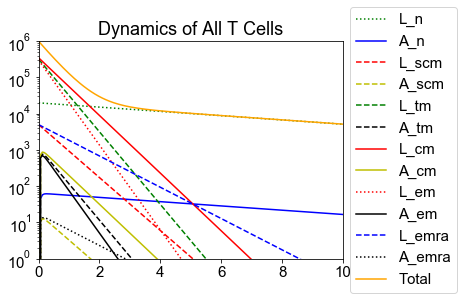

In [70]:
fig, ax = plt.subplots(figsize = (15,4), sharey = True)
ax = plt.subplot(121)
plt.title('Dynamics of All T Cells')
plt.plot(t,L_n,'g:',label='L_n')
plt.plot(t,A_n,'b-',label='A_n')
plt.plot(t,L_scm,'r--',label='L_scm')
plt.plot(t,A_scm,'y--',label='A_scm')
plt.plot(t,L_tm,'g--',label='L_tm')
plt.plot(t,A_tm,'k--',label='A_tm')
plt.plot(t,L_cm,'r',label='L_cm')
plt.plot(t,A_cm,'y-',label='A_cm')
plt.plot(t,L_em,'r:',label='L_em')
plt.plot(t,A_em,'k-',label='A_em')
plt.plot(t,L_emra,'b--',label='L_emra')
plt.plot(t,A_emra,'k:',label='A_emra')
plt.plot(t,Total,'orange', label = 'Total')
plt.yscale('log')
plt.ylim([1,10**6])
plt.xlim([0,10])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [71]:
def HIV_decay(L0,t):
    L_t = L0 * np.exp(-5.2*10**-4*t) 
    return L_t
t = np.linspace(0,tn-1, b)
L_t = []
for tmp in t:
    L_t.append(HIV_decay(10**6, tmp))

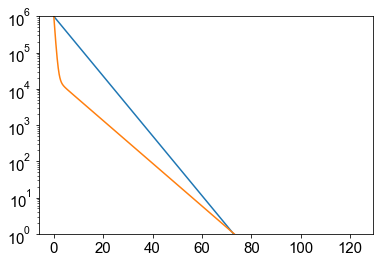

In [72]:
plt.plot(t/365, L_t, label = 'Decay from Siciliano')
plt.plot(t/365, Total, label = 'Estimated from Model')
plt.ylim([1,10**6])
plt.yscale('log')

In [135]:
w_tmp = (lhs(1, samples=1000)*3).flatten()
parameter_arr = w_tmp
parameter_letter = 'w'


#number of time points
tn = 2000

#store solutions
L_n = np.zeros([w_tmp.shape[0],tn])
L_scm = np.zeros([w_tmp.shape[0],tn])
L_tm = np.zeros([w_tmp.shape[0],tn])
L_cm = np.zeros([w_tmp.shape[0],tn])
L_em = np.zeros([w_tmp.shape[0],tn])
L_emra = np.zeros([w_tmp.shape[0],tn])

A_n = np.zeros([w_tmp.shape[0],tn])
A_scm = np.zeros([w_tmp.shape[0],tn])
A_tm = np.zeros([w_tmp.shape[0],tn])
A_cm = np.zeros([w_tmp.shape[0],tn])
A_em = np.zeros([w_tmp.shape[0],tn])
A_emra = np.zeros([w_tmp.shape[0],tn])
Total = np.zeros([w_tmp.shape[0],tn])




for i,parameter in enumerate(parameter_arr):
#initial conditions, there are three
    w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
    d = 1
    LRA = 1
    d_ALL = 0.003

    if parameter_letter == 'w':
        w = parameter
    elif parameter_letter == 'd_ALL':
        d_ALL = parameter
    elif parameter_letter == 'd':
        d = parameter
    elif parameter_letter == 'LRA':
        LRA = parameter
    else: 
        break
    #set parameters

    p_cm = 0.00075 * d
    p_tm = 0.0006 * d
    p_em = 0.0003 * d
    p_n = 0.000099 * d
    p_scm = 0.00001 * d
    p_emra = 0.00005 * d


    corr_fact = -np.log(1/2)
    d_n = corr_fact * (1/1500)
    d_scm = corr_fact * (1/150)
    d_tm = corr_fact * (1/100)
    d_cm = corr_fact * (1/120)
    d_em = corr_fact * (1/90)
    d_emra = corr_fact * (1/250)
    n = 0.00017
    a = n * LRA

    
    z0 = np.zeros(12)
    ctr=0
    for g in range(6):
        z0[ctr] = u_T[g]*10**6
        ctr+=2

    #time points
    b = 2000
    tn = 30001
    t = np.linspace(0,tn-1, b)


    #record intial

    L_n[i][0] = z0[0]
    L_scm[i][0] = z0[2]
    L_tm[i][0] = z0[4]
    L_cm[i][0] = z0[6] 
    L_em[i][0] = z0[8]
    L_emra[i][0] =z0[10]

    A_n[i][0] = z0[1]
    A_scm[i][0] = z0[3]
    A_tm[i][0] = z0[5]
    A_cm[i][0] = z0[7]
    A_em[i][0] = z0[9]
    A_emra[i][0] = z0[11]

    Total[i][0] = np.sum(z0)

    #Solve the ODE
    for k in range(1,b):
        tspan = [t[k-1],t[k]]
        # solve for next step
        z = odeint(model,z0,tspan)
        # store solution for plotting

        L_n[i][k] = z[1][0]
        L_scm[i][k] = z[1][2]
        L_tm[i][k] = z[1][4]
        L_cm[i][k] = z[1][6] 
        L_em[i][k] = z[1][8]
        L_emra[i][k] = z[1][10]

        A_n[i][k] = z[1][1]
        A_scm[i][k] = z[1][3]
        A_tm[i][k] = z[1][5]
        A_cm[i][k] = z[1][7]
        A_em[i][k] = z[1][9]
        A_emra[i][k] = z[1][11]


        Total[i][k] =np.sum(z[1])
        z0 = z[1] 
    sys.stdout.write('\r {}'.format(i) )

t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 999

In [136]:
pop_dict['w'] = w_tmp

In [137]:
pickle.dump(pop_dict,open('190430_w_sensitivity.p', 'wb'))

In [138]:
y = pop_dict['total'][np.argsort(w_tmp)]
x  = sorted(w_tmp)


In [139]:
hill_cure = []
for i in range(1000):
    hill_cure.append(t[np.where(y[i] <10**2)[0][0]])
y = hill_cure

[None, None, None, None, None, None, None, None, None, None, None, None]

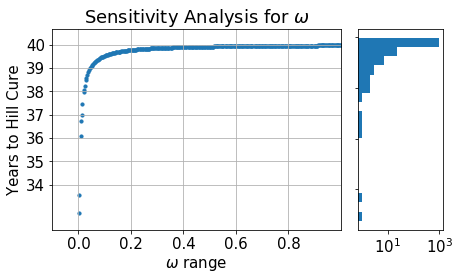

In [150]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (7,5))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
plt.grid(True)
plt.xticks(np.arange(0, 1, .2))
plt.yticks(np.arange(34,41,1))
plt.xlim([-.1,1])
ax_joint.set_xlabel(r'$\omega$ range')
ax_joint.set_ylabel('Years to Hill Cure')
plt.title(r'Sensitivity Analysis for $\omega$')
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y, s = 10)


ax_marg_y.hist(y,orientation="horizontal", log = True,bins = 20)

plt.setp(ax_marg_y.get_yticklabels(), visible=False)




